# Sentiment analysis of tweets on user level
Author: Daheng Wang  
Last modified: 2017-09-21

# Roadmap
1. Filter out interested IBM/non-IBM users
2. Build user documents for all his/her tweets in database
3. Perform sentiment analysis on all user documents
4. Plot world cloud of positive/negative documents

# Steps

In [1]:
"""
Initialization
"""

'''
Data analysis modules: pandas, matplotlib, numpy, and etc.
'''
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # render double resolution plot output for Retina screens 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from textblob import TextBlob
from wordcloud import WordCloud,STOPWORDS

'''
Standard modules, MongoDB modules
'''
import os, sys, json, datetime, pickle, multiprocessing, logging, codecs, re
from pprint import pprint

import pymongo
from pymongo import IndexModel, ASCENDING, DESCENDING

'''
Custom tool modules
'''
import mongodb  # module for setting up connection with (local) MongoDB database
import multiprocessing_workers  # module for splitting workloads between processes
import utilities  # module for various custom utility functions
from config import * # import all global configuration variables

'''
Misc
'''
NB_NAME = '20170921-user_tweets_sentiment'

## 1. Filter out interested IBM/non-IBM users

In [2]:
"""
Read in M1 IBM users. Check avg/mean tweets number.
"""
if 0 == 1:
    '''
    Load lists of IBM users
    '''
    user_nt_ibm_desc_ids_lst = []
    with open(USER_NT_IBM_DESC_IDS_LST_PKL, 'rb') as f:
        user_nt_ibm_desc_ids_lst = pickle.load(f)
    user_nt_ibm_desc_ids_set = set(user_nt_ibm_desc_ids_lst)
    
    '''
    Read in simple influence df
    '''
    df = pd.read_pickle(SIMPLE_INFLUENCE_PKL)
    df = df.fillna(0)
    
    '''
    Build dfs for IBM/non-IBM users
    '''
    user_nt_ibm_desc_cond = df['uid'].isin(user_nt_ibm_desc_ids_set)
    df_user_nt_ibm_desc = df[user_nt_ibm_desc_cond]
    df_user_nt_nonibm_desc = df[~ user_nt_ibm_desc_cond]

In [8]:
user_ibm_sent_pkl = os.path.join(TMP_DIR, '{}-{}'.format(NB_NAME, 'user_ibm_sent.df.pkl'))
user_nonibm_sent_pkl = os.path.join(TMP_DIR, '{}-{}'.format(NB_NAME, 'user_nonibm_sent.df.pkl'))

In [4]:
"""
Filter out interested IBM users.
Sample out same number of interested non-IBM users.
Pickle user ids for interested IBM/non-IBM users.
"""
if 0 == 1:
    ibm_users_avg_tw_number = 12.9
    df_user_ibm_sent = df_user_nt_ibm_desc[df_user_nt_ibm_desc['n_n'] > ibm_users_avg_tw_number]
    df_user_ibm_sent.to_pickle(user_ibm_sent_pkl)
    
    interested_user_num = df_user_ibm_sent.shape[0]
    df_user_nonibm_sent = df_user_nt_nonibm_desc[df_user_nt_nonibm_desc['n_n'] > 12].sample(n=interested_user_num)
    df_user_nonibm_sent.to_pickle(user_nonibm_sent_pkl)
    
    print('Done!')

Done!


## 2. Build user documents for all his/her tweets in database

In [2]:
"""
For each interested user, query MongoDB for all his/her tweets, merge 'text' filed together and write into a new file.
"""
ibm_user_sent_dir = os.path.join(TMP_DIR, 'ibm_user_sent/')
nonibm_user_sent_dir = os.path.join(TMP_DIR, 'nonibm_user_sent/')

In [6]:
%%time
"""
Interested IBM user
"""
if 0 == 1:
    '''
    Read in pickle data
    '''
    df = pd.read_pickle(user_ibm_sent_pkl)
    
    '''
    Query MongoDB and append into new file
    '''
    user_ids_lst = df['uid'].tolist()
    tw_nt_col = mongodb.initialize(db_name=DB_NAME, collection_name=TW_NT_COL)
    
    for user_id in user_ids_lst:
        user_file = os.path.join(ibm_user_sent_dir, '{}.txt'.format(user_id))
        with codecs.open(user_file, 'w', 'utf-8') as f:
            print('Writing to {}...'.format(user_file), end=' ')
            cursor = tw_nt_col.find(filter={'user.id': {'$eq': user_id}}, projection={'_id': 0, 'id': 1, 'text': 1})
            for doc in cursor:
                text = doc['text'].replace('\n','')
                f.write(text + '\n')   
            print('Done!')

MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!
Writing to ./tmp/ibm_user_sent/617383.txt... Done!
Writing to ./tmp/ibm_user_sent/806297.txt... Done!
Writing to ./tmp/ibm_user_sent/807976.txt... Done!
Writing to ./tmp/ibm_user_sent/812660.txt... Done!
Writing to ./tmp/ibm_user_sent/848901.txt... Done!
Writing to ./tmp/ibm_user_sent/1421831.txt... Done!
Writing to ./tmp/ibm_user_sent/1878911.txt... Done!
Writing to ./tmp/ibm_user_sent/2146491.txt... Done!
Writing to ./tmp/ibm_user_sent/2326481.txt... Done!
Writing to ./tmp/ibm_user_sent/3633291.txt... Done!
Writing to ./tmp/ibm_user_sent/3906851.txt... Done!
Writing to ./tmp/ibm_user_sent/4067601.txt... Done!
Writing to ./tmp/ibm_user_sent/5758352.txt... Done!
Writing to ./tmp/ibm_user_sent/6063202.txt... Done!
Writing to ./tmp/ibm_user_sent/6982552.txt... Done!
Writing to ./tmp/ibm_user_sent/7001342.txt... Done!
Writing to ./tmp/ibm_user_sent/8156132.txt... Done!
Writing to ./tmp/ibm_user_sent/9003562.txt... Done!


Writing to ./tmp/ibm_user_sent/21132950.txt... Done!
Writing to ./tmp/ibm_user_sent/21195330.txt... Done!
Writing to ./tmp/ibm_user_sent/21199027.txt... Done!
Writing to ./tmp/ibm_user_sent/21229836.txt... Done!
Writing to ./tmp/ibm_user_sent/21377448.txt... Done!
Writing to ./tmp/ibm_user_sent/21434850.txt... Done!
Writing to ./tmp/ibm_user_sent/21441630.txt... Done!
Writing to ./tmp/ibm_user_sent/21646881.txt... Done!
Writing to ./tmp/ibm_user_sent/21764817.txt... Done!
Writing to ./tmp/ibm_user_sent/21888204.txt... Done!
Writing to ./tmp/ibm_user_sent/21993980.txt... Done!
Writing to ./tmp/ibm_user_sent/22004821.txt... Done!
Writing to ./tmp/ibm_user_sent/22063434.txt... Done!
Writing to ./tmp/ibm_user_sent/22070583.txt... Done!
Writing to ./tmp/ibm_user_sent/22145868.txt... Done!
Writing to ./tmp/ibm_user_sent/22169155.txt... Done!
Writing to ./tmp/ibm_user_sent/22316164.txt... Done!
Writing to ./tmp/ibm_user_sent/22338925.txt... Done!
Writing to ./tmp/ibm_user_sent/22493195.txt...

Writing to ./tmp/ibm_user_sent/56717522.txt... Done!
Writing to ./tmp/ibm_user_sent/57187577.txt... Done!
Writing to ./tmp/ibm_user_sent/57268221.txt... Done!
Writing to ./tmp/ibm_user_sent/58225301.txt... Done!
Writing to ./tmp/ibm_user_sent/58744036.txt... Done!
Writing to ./tmp/ibm_user_sent/58745031.txt... Done!
Writing to ./tmp/ibm_user_sent/59225033.txt... Done!
Writing to ./tmp/ibm_user_sent/60272377.txt... Done!
Writing to ./tmp/ibm_user_sent/60532885.txt... Done!
Writing to ./tmp/ibm_user_sent/60678488.txt... Done!
Writing to ./tmp/ibm_user_sent/60888510.txt... Done!
Writing to ./tmp/ibm_user_sent/62493927.txt... Done!
Writing to ./tmp/ibm_user_sent/64165215.txt... Done!
Writing to ./tmp/ibm_user_sent/64781301.txt... Done!
Writing to ./tmp/ibm_user_sent/65017508.txt... Done!
Writing to ./tmp/ibm_user_sent/65057697.txt... Done!
Writing to ./tmp/ibm_user_sent/65396745.txt... Done!
Writing to ./tmp/ibm_user_sent/67597472.txt... Done!
Writing to ./tmp/ibm_user_sent/68449292.txt...

Writing to ./tmp/ibm_user_sent/383666116.txt... Done!
Writing to ./tmp/ibm_user_sent/384798150.txt... Done!
Writing to ./tmp/ibm_user_sent/385299993.txt... Done!
Writing to ./tmp/ibm_user_sent/385702849.txt... Done!
Writing to ./tmp/ibm_user_sent/388356133.txt... Done!
Writing to ./tmp/ibm_user_sent/389068268.txt... Done!
Writing to ./tmp/ibm_user_sent/389669484.txt... Done!
Writing to ./tmp/ibm_user_sent/390673164.txt... Done!
Writing to ./tmp/ibm_user_sent/390845352.txt... Done!
Writing to ./tmp/ibm_user_sent/392623423.txt... Done!
Writing to ./tmp/ibm_user_sent/393272622.txt... Done!
Writing to ./tmp/ibm_user_sent/393443307.txt... Done!
Writing to ./tmp/ibm_user_sent/393463327.txt... Done!
Writing to ./tmp/ibm_user_sent/394535041.txt... Done!
Writing to ./tmp/ibm_user_sent/395067213.txt... Done!
Writing to ./tmp/ibm_user_sent/395108897.txt... Done!
Writing to ./tmp/ibm_user_sent/397336671.txt... Done!
Writing to ./tmp/ibm_user_sent/401620804.txt... Done!
Writing to ./tmp/ibm_user_se

Writing to ./tmp/ibm_user_sent/2384843142.txt... Done!
Writing to ./tmp/ibm_user_sent/2390085150.txt... Done!
Writing to ./tmp/ibm_user_sent/2401316876.txt... Done!
Writing to ./tmp/ibm_user_sent/2401585183.txt... Done!
Writing to ./tmp/ibm_user_sent/2407488865.txt... Done!
Writing to ./tmp/ibm_user_sent/2409379634.txt... Done!
Writing to ./tmp/ibm_user_sent/2409456481.txt... Done!
Writing to ./tmp/ibm_user_sent/2410977194.txt... Done!
Writing to ./tmp/ibm_user_sent/2413022749.txt... Done!
Writing to ./tmp/ibm_user_sent/2414137304.txt... Done!
Writing to ./tmp/ibm_user_sent/2424736675.txt... Done!
Writing to ./tmp/ibm_user_sent/2425982534.txt... Done!
Writing to ./tmp/ibm_user_sent/2427660650.txt... Done!
Writing to ./tmp/ibm_user_sent/2433196682.txt... Done!
Writing to ./tmp/ibm_user_sent/2445661700.txt... Done!
Writing to ./tmp/ibm_user_sent/2458106965.txt... Done!
Writing to ./tmp/ibm_user_sent/2475187202.txt... Done!
Writing to ./tmp/ibm_user_sent/2478745052.txt... Done!
Writing to

Writing to ./tmp/ibm_user_sent/3401387440.txt... Done!
Writing to ./tmp/ibm_user_sent/3414725841.txt... Done!
Writing to ./tmp/ibm_user_sent/3430063006.txt... Done!
Writing to ./tmp/ibm_user_sent/3437977829.txt... Done!
Writing to ./tmp/ibm_user_sent/3490249632.txt... Done!
Writing to ./tmp/ibm_user_sent/3529776386.txt... Done!
Writing to ./tmp/ibm_user_sent/3613464501.txt... Done!
Writing to ./tmp/ibm_user_sent/3688660222.txt... Done!
Writing to ./tmp/ibm_user_sent/3744699792.txt... Done!
Writing to ./tmp/ibm_user_sent/3750090732.txt... Done!
Writing to ./tmp/ibm_user_sent/3753644356.txt... Done!
Writing to ./tmp/ibm_user_sent/3794183055.txt... Done!
Writing to ./tmp/ibm_user_sent/3804079157.txt... Done!
Writing to ./tmp/ibm_user_sent/3812913855.txt... Done!
Writing to ./tmp/ibm_user_sent/3873633132.txt... Done!
Writing to ./tmp/ibm_user_sent/3880260395.txt... Done!
Writing to ./tmp/ibm_user_sent/3883712133.txt... Done!
Writing to ./tmp/ibm_user_sent/3887143637.txt... Done!
Writing to

In [7]:
"""
Interested non-IBM user
"""
if 0 == 1:
    '''
    Read in pickle data
    '''
    df = pd.read_pickle(user_nonibm_sent_pkl)
    
    '''
    Query MongoDB and append into new file
    '''
    user_ids_lst = df['uid'].tolist()
    tw_nt_col = mongodb.initialize(db_name=DB_NAME, collection_name=TW_NT_COL)
    
    for user_id in user_ids_lst:
        user_file = os.path.join(nonibm_user_sent_dir, '{}.txt'.format(user_id))
        with codecs.open(user_file, 'w', 'utf-8') as f:
            print('Writing to {}...'.format(user_file), end=' ')
            cursor = tw_nt_col.find(filter={'user.id': {'$eq': user_id}}, projection={'_id': 0, 'id': 1, 'text': 1})
            for doc in cursor:
                text = doc['text'].replace('\n','')
                f.write(text + '\n')   
            print('Done!')

MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!
Writing to ./tmp/nonibm_user_sent/55219580.txt... Done!
Writing to ./tmp/nonibm_user_sent/593222868.txt... Done!
Writing to ./tmp/nonibm_user_sent/367661791.txt... Done!
Writing to ./tmp/nonibm_user_sent/3187507858.txt... Done!
Writing to ./tmp/nonibm_user_sent/60003825.txt... Done!
Writing to ./tmp/nonibm_user_sent/87488097.txt... Done!
Writing to ./tmp/nonibm_user_sent/94397736.txt... Done!
Writing to ./tmp/nonibm_user_sent/271462326.txt... Done!
Writing to ./tmp/nonibm_user_sent/33348029.txt... Done!
Writing to ./tmp/nonibm_user_sent/77962428.txt... Done!
Writing to ./tmp/nonibm_user_sent/4078445121.txt... Done!
Writing to ./tmp/nonibm_user_sent/28784703.txt... Done!
Writing to ./tmp/nonibm_user_sent/250296658.txt... Done!
Writing to ./tmp/nonibm_user_sent/17380002.txt... Done!
Writing to ./tmp/nonibm_user_sent/823713364350095360.txt... Done!
Writing to ./tmp/nonibm_user_sent/962954390.txt... Done!
Writing to ./tmp

Writing to ./tmp/nonibm_user_sent/1526276143.txt... Done!
Writing to ./tmp/nonibm_user_sent/2409390320.txt... Done!
Writing to ./tmp/nonibm_user_sent/23020091.txt... Done!
Writing to ./tmp/nonibm_user_sent/2274226879.txt... Done!
Writing to ./tmp/nonibm_user_sent/722759532854648833.txt... Done!
Writing to ./tmp/nonibm_user_sent/15729315.txt... Done!
Writing to ./tmp/nonibm_user_sent/3367349775.txt... Done!
Writing to ./tmp/nonibm_user_sent/2916073845.txt... Done!
Writing to ./tmp/nonibm_user_sent/364368248.txt... Done!
Writing to ./tmp/nonibm_user_sent/143821626.txt... Done!
Writing to ./tmp/nonibm_user_sent/802586935.txt... Done!
Writing to ./tmp/nonibm_user_sent/839782036827062272.txt... Done!
Writing to ./tmp/nonibm_user_sent/809348340215402496.txt... Done!
Writing to ./tmp/nonibm_user_sent/14326090.txt... Done!
Writing to ./tmp/nonibm_user_sent/82114365.txt... Done!
Writing to ./tmp/nonibm_user_sent/2769549002.txt... Done!
Writing to ./tmp/nonibm_user_sent/2801598336.txt... Done!
W

Writing to ./tmp/nonibm_user_sent/61936930.txt... Done!
Writing to ./tmp/nonibm_user_sent/1708051141.txt... Done!
Writing to ./tmp/nonibm_user_sent/893740471.txt... Done!
Writing to ./tmp/nonibm_user_sent/106504852.txt... Done!
Writing to ./tmp/nonibm_user_sent/385686492.txt... Done!
Writing to ./tmp/nonibm_user_sent/2331383155.txt... Done!
Writing to ./tmp/nonibm_user_sent/483156765.txt... Done!
Writing to ./tmp/nonibm_user_sent/974856121.txt... Done!
Writing to ./tmp/nonibm_user_sent/17836215.txt... Done!
Writing to ./tmp/nonibm_user_sent/576104227.txt... Done!
Writing to ./tmp/nonibm_user_sent/766401110693318656.txt... Done!
Writing to ./tmp/nonibm_user_sent/80895258.txt... Done!
Writing to ./tmp/nonibm_user_sent/565888564.txt... Done!
Writing to ./tmp/nonibm_user_sent/29358764.txt... Done!
Writing to ./tmp/nonibm_user_sent/160303004.txt... Done!
Writing to ./tmp/nonibm_user_sent/24855822.txt... Done!
Writing to ./tmp/nonibm_user_sent/36692104.txt... Done!
Writing to ./tmp/nonibm_us

Writing to ./tmp/nonibm_user_sent/76295423.txt... Done!
Writing to ./tmp/nonibm_user_sent/716227436049014784.txt... Done!
Writing to ./tmp/nonibm_user_sent/2875102389.txt... Done!
Writing to ./tmp/nonibm_user_sent/827226084718542848.txt... Done!
Writing to ./tmp/nonibm_user_sent/3240302326.txt... Done!
Writing to ./tmp/nonibm_user_sent/68583134.txt... Done!
Writing to ./tmp/nonibm_user_sent/29788121.txt... Done!
Writing to ./tmp/nonibm_user_sent/3904948470.txt... Done!
Writing to ./tmp/nonibm_user_sent/769931163116896256.txt... Done!
Writing to ./tmp/nonibm_user_sent/429580982.txt... Done!
Writing to ./tmp/nonibm_user_sent/65381936.txt... Done!
Writing to ./tmp/nonibm_user_sent/716669221644558336.txt... Done!
Writing to ./tmp/nonibm_user_sent/4411041.txt... Done!
Writing to ./tmp/nonibm_user_sent/18517080.txt... Done!
Writing to ./tmp/nonibm_user_sent/2252406138.txt... Done!
Writing to ./tmp/nonibm_user_sent/19940700.txt... Done!
Writing to ./tmp/nonibm_user_sent/569032482.txt... Done!

Writing to ./tmp/nonibm_user_sent/261452842.txt... Done!
Writing to ./tmp/nonibm_user_sent/15392736.txt... Done!
Writing to ./tmp/nonibm_user_sent/20448383.txt... Done!
Writing to ./tmp/nonibm_user_sent/3534222021.txt... Done!
Writing to ./tmp/nonibm_user_sent/89191817.txt... Done!
Writing to ./tmp/nonibm_user_sent/6869872.txt... Done!
Writing to ./tmp/nonibm_user_sent/15426896.txt... Done!
Writing to ./tmp/nonibm_user_sent/15221663.txt... Done!
Writing to ./tmp/nonibm_user_sent/19995298.txt... Done!
Writing to ./tmp/nonibm_user_sent/622857704.txt... Done!
Writing to ./tmp/nonibm_user_sent/175282603.txt... Done!
Writing to ./tmp/nonibm_user_sent/817402429490786304.txt... Done!
Writing to ./tmp/nonibm_user_sent/67100074.txt... Done!
Writing to ./tmp/nonibm_user_sent/4793754197.txt... Done!
Writing to ./tmp/nonibm_user_sent/627456572.txt... Done!
Writing to ./tmp/nonibm_user_sent/17712544.txt... Done!
Writing to ./tmp/nonibm_user_sent/20092572.txt... Done!
Writing to ./tmp/nonibm_user_se

## 3. Perform sentiment analysis on all user documents

In [3]:
user_ibm_pol_pkl = os.path.join(TMP_DIR, '{}-{}'.format(NB_NAME, 'user_ibm_pol.df.pkl'))
user_nonibm_pol_pkl = os.path.join(TMP_DIR, '{}-{}'.format(NB_NAME, 'user_nonibm_pol.df.pkl'))

In [6]:
def preprocessTweet(tweet):
    """
    Preprocess the 'text' filed of tweet
    """
    
    '''
    Convert to lower case
    '''
    tweet = tweet.lower()
    
    '''
    Remove www.* or https?://* to URL
    '''
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)
    
    '''
    Remove @username
    '''
    tweet = re.sub('@[^\s]+',' ',tweet)
    
    '''
    Remove additional white spaces
    '''
    tweet = re.sub('[\s]+', ' ', tweet)
    
    '''
    Replace #word with word
    '''
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    '''
    Trim
    '''
    tweet = tweet.strip('\'"')
    
    return tweet

In [28]:
%%time
'''
IBM users
'''
if 0 == 1:
    results_df = pd.DataFrame(columns=('uid', 'ibm', 'polarity'))
    df = pd.read_pickle(user_ibm_sent_pkl)
    ibm_user_ids_lst = df['uid'].tolist()
    for user_id in ibm_user_ids_lst:
        user_file = os.path.join(ibm_user_sent_dir, '{}.txt'.format(user_id))
        doc_str_lst = []
        with codecs.open(user_file, 'r', 'utf-8') as f:
            for line in f:
                doc_str_lst.append(line)
            doc_str = ''.join(doc_str_lst)
            doc_str = preprocessTweet(doc_str)
            doc_str_polarity = TextBlob(doc_str).sentiment.polarity
            results_df = results_df.append([{'uid': user_id, 'ibm': 1, 'polarity': doc_str_polarity}], ignore_index=True)
    results_df.to_pickle(user_ibm_pol_pkl)

CPU times: user 20.2 s, sys: 96 ms, total: 20.3 s
Wall time: 20.3 s


In [11]:
%%time
'''
Non-IBM users
'''
if 0 == 1:
    results_df = pd.DataFrame(columns=('uid', 'ibm', 'polarity'))
    df = pd.read_pickle(user_nonibm_sent_pkl)
    ibm_user_ids_lst = df['uid'].tolist()
    for user_id in ibm_user_ids_lst:
        user_file = os.path.join(nonibm_user_sent_dir, '{}.txt'.format(user_id))
        doc_str_lst = []
        with codecs.open(user_file, 'r', 'utf-8') as f:
            for line in f:
                doc_str_lst.append(line)
            doc_str = ''.join(doc_str_lst)
            doc_str = preprocessTweet(doc_str)
            doc_str_polarity = TextBlob(doc_str).sentiment.polarity
            results_df = results_df.append([{'uid': user_id, 'ibm': 0, 'polarity': doc_str_polarity}], ignore_index=True)
    results_df.to_pickle(user_nonibm_pol_pkl)

CPU times: user 23.9 s, sys: 104 ms, total: 24 s
Wall time: 24 s


## Plot

In [5]:
if 1 == 1:
    df_ibm = pd.read_pickle(user_ibm_pol_pkl)
    df_nonibm = pd.read_pickle(user_nonibm_pol_pkl)

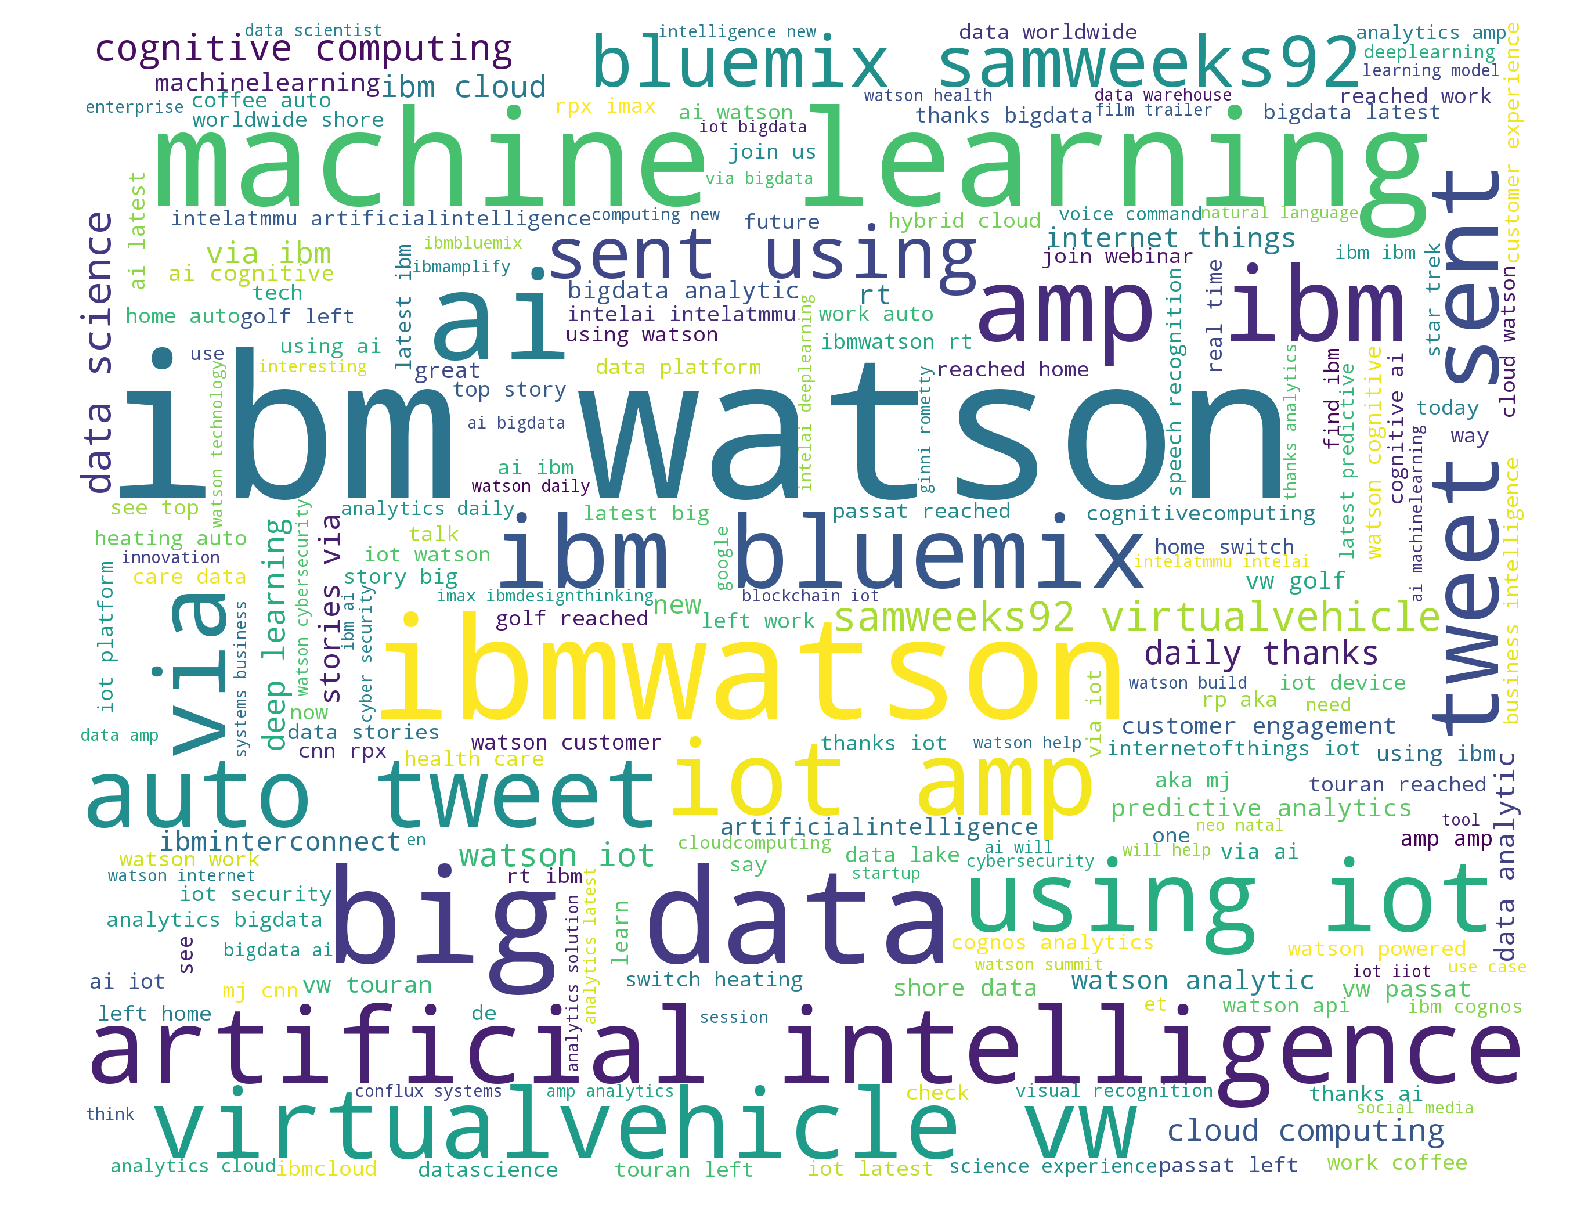

In [9]:
if 1 == 1:
    df = pd.read_pickle(user_ibm_sent_pkl)
    ibm_user_ids_lst = df['uid'].tolist()
    
    str_lst = []
    for user_id in ibm_user_ids_lst:
        user_file = os.path.join(ibm_user_sent_dir, '{}.txt'.format(user_id))
        
        with codecs.open(user_file, 'r', 'utf-8') as f:
            for line in f:
                str_lst.append(line)
    
    wc_data = ''.join(str_lst)
    wc_data = preprocessTweet(wc_data)
    
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=2500, height=2000).generate(wc_data)
    plt.figure(1, figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

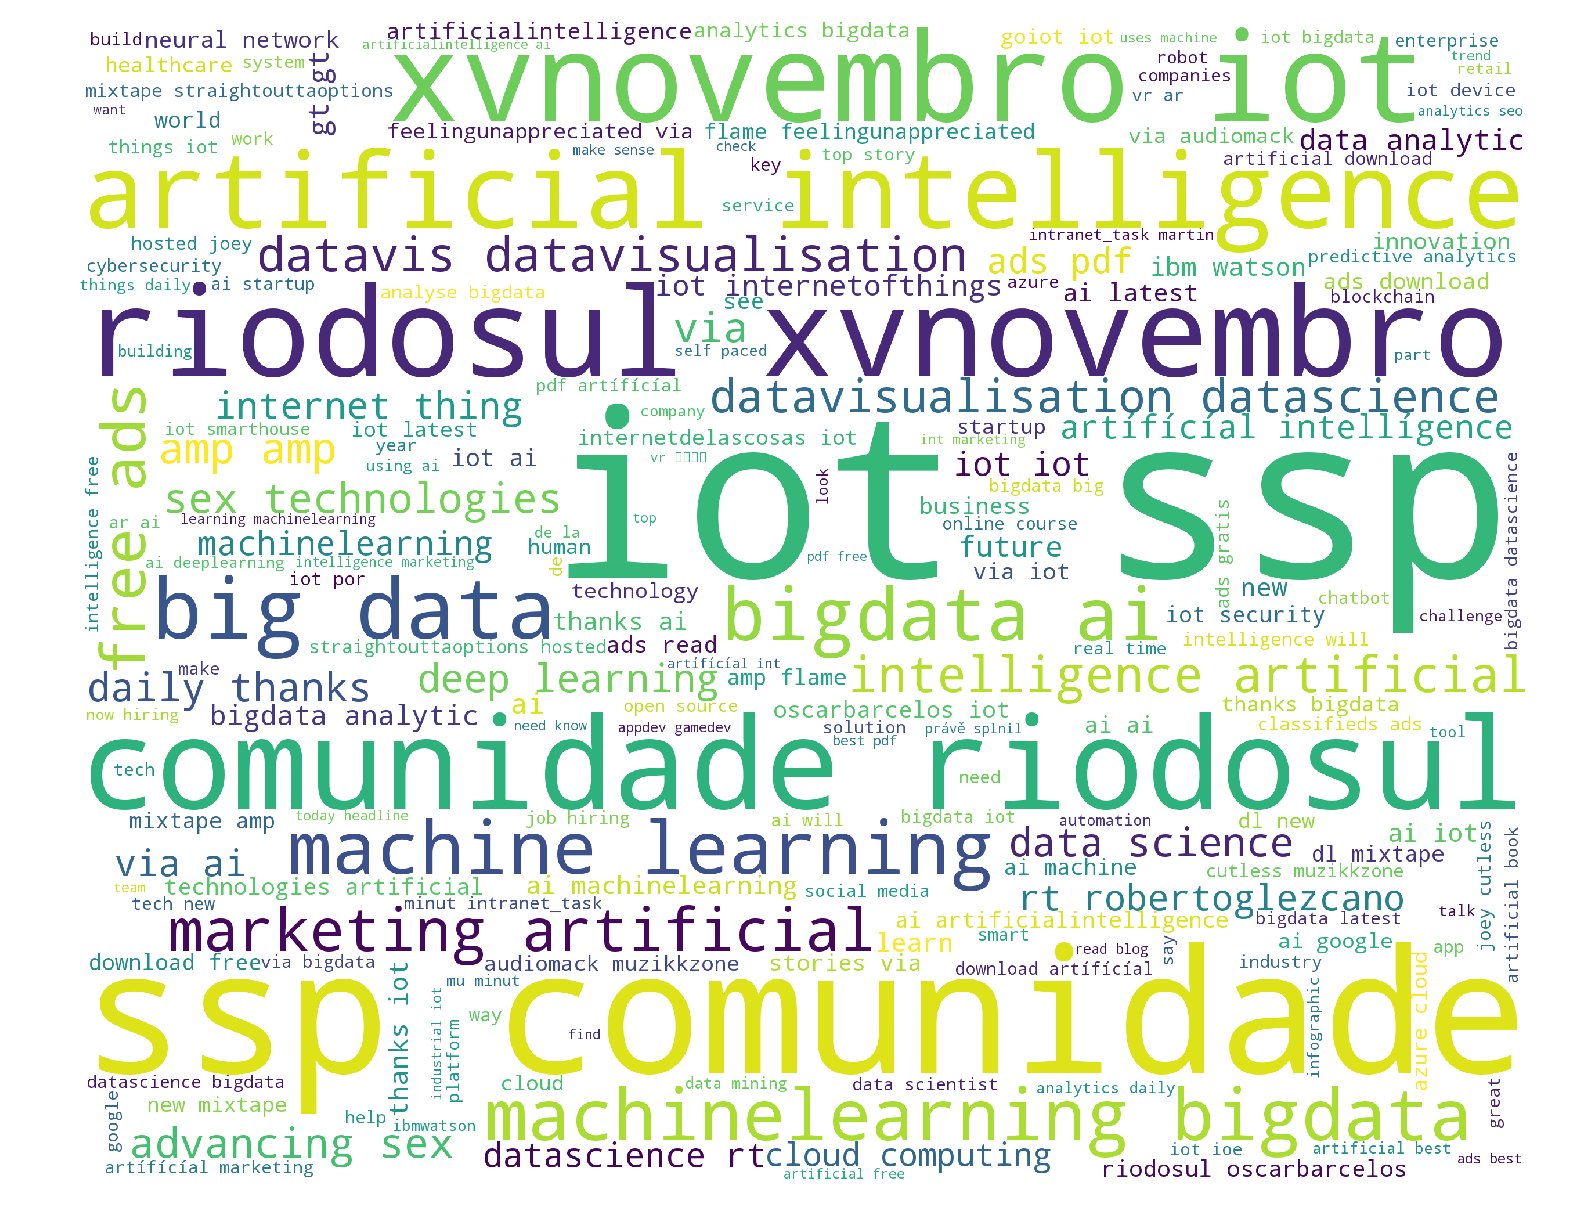

In [11]:
if 1 == 1:
    df = pd.read_pickle(user_nonibm_sent_pkl)
    nonibm_user_ids_lst = df['uid'].tolist()
    
    str_lst = []
    for user_id in nonibm_user_ids_lst:
        user_file = os.path.join(nonibm_user_sent_dir, '{}.txt'.format(user_id))
        
        with codecs.open(user_file, 'r', 'utf-8') as f:
            for line in f:
                str_lst.append(line)
    
    wc_data = ''.join(str_lst)
    wc_data = preprocessTweet(wc_data)
    
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=2500, height=2000).generate(wc_data)
    plt.figure(1, figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

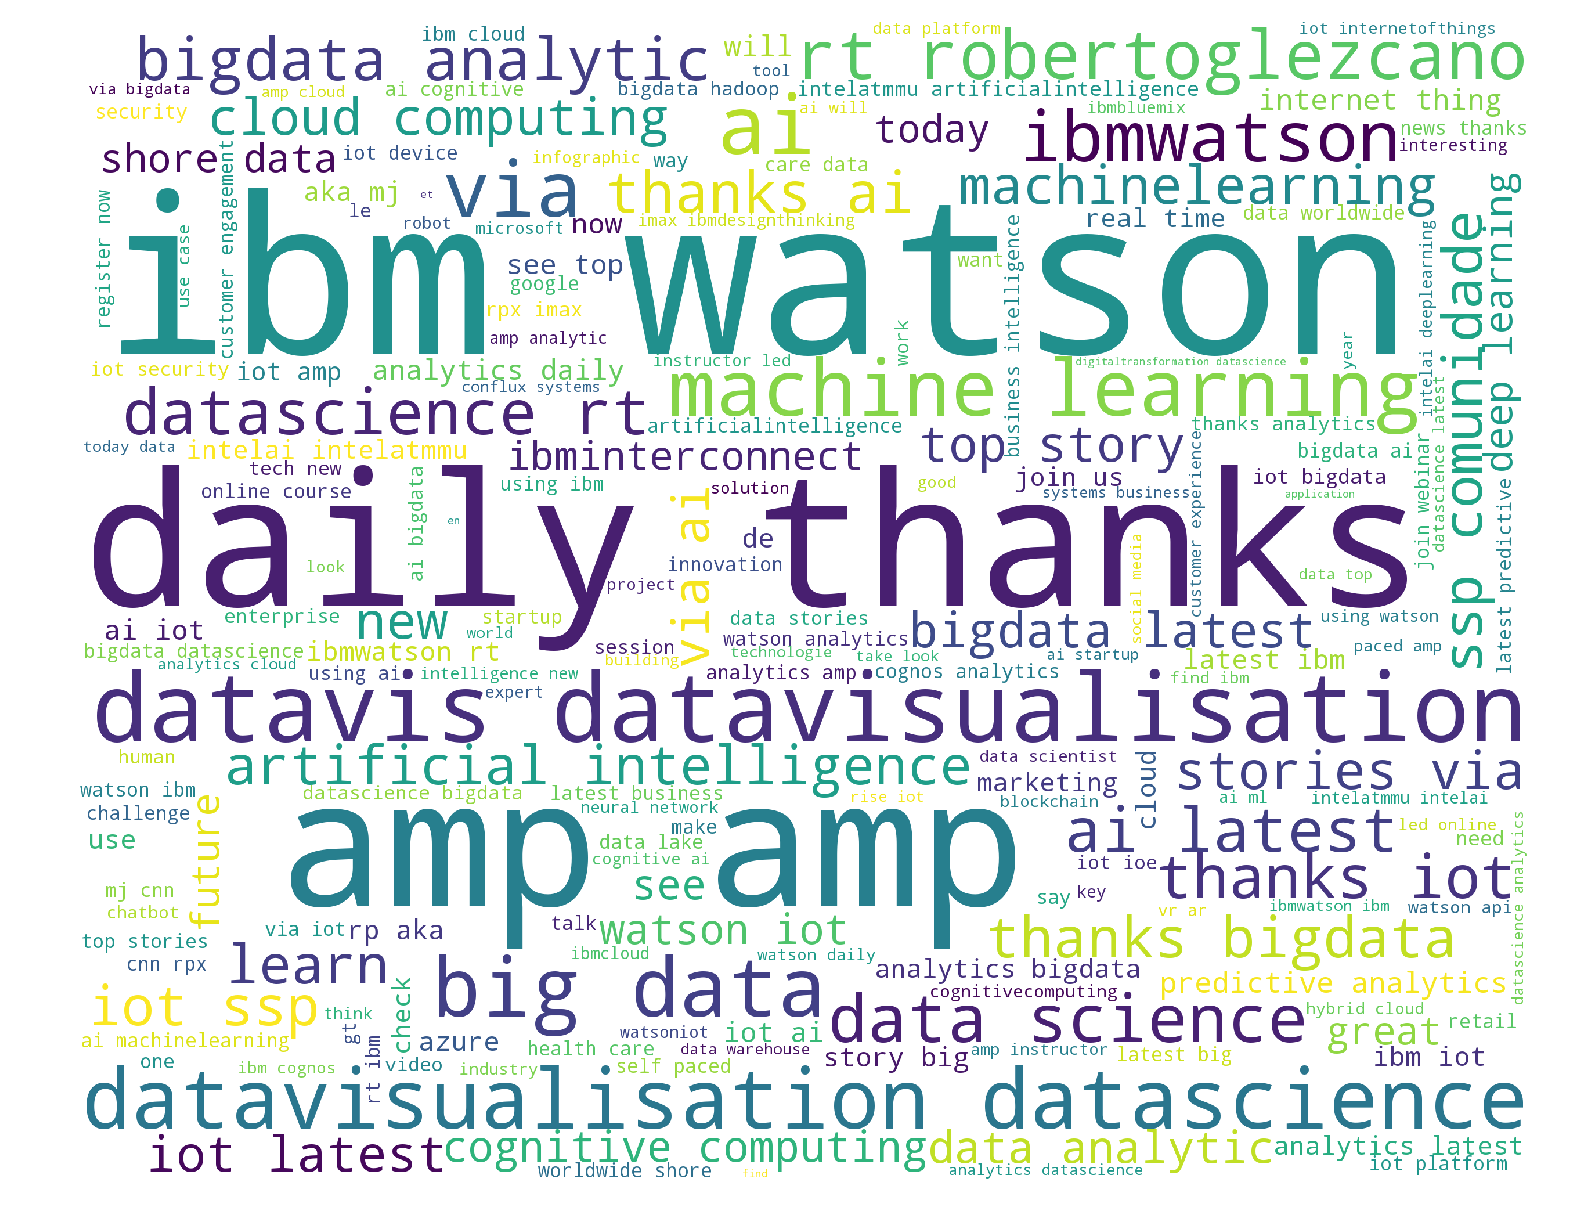

In [14]:
if 1 == 1:
    str_lst = []
    
    df_ibm = pd.read_pickle(user_ibm_pol_pkl)
    ibm_pos_ids_lst = df_ibm[df_ibm['polarity'] > 0.16]['uid'].tolist()
    
    for user_id in ibm_pos_ids_lst:
        user_file = os.path.join(ibm_user_sent_dir, '{}.txt'.format(user_id))
        with codecs.open(user_file, 'r', 'utf-8') as f:
            for line in f:
                str_lst.append(line)
                
    df_nonibm = pd.read_pickle(user_nonibm_pol_pkl)
    nonibm_pos_ids_lst = df_nonibm[df_nonibm['polarity'] > 0.16]['uid'].tolist()
    
    for user_id in nonibm_pos_ids_lst:
        user_file = os.path.join(nonibm_user_sent_dir, '{}.txt'.format(user_id))
        with codecs.open(user_file, 'r', 'utf-8') as f:
            for line in f:
                str_lst.append(line)
    
    wc_data = ''.join(str_lst)
    wc_data = preprocessTweet(wc_data)
    
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=2500, height=2000).generate(wc_data)
    plt.figure(1, figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

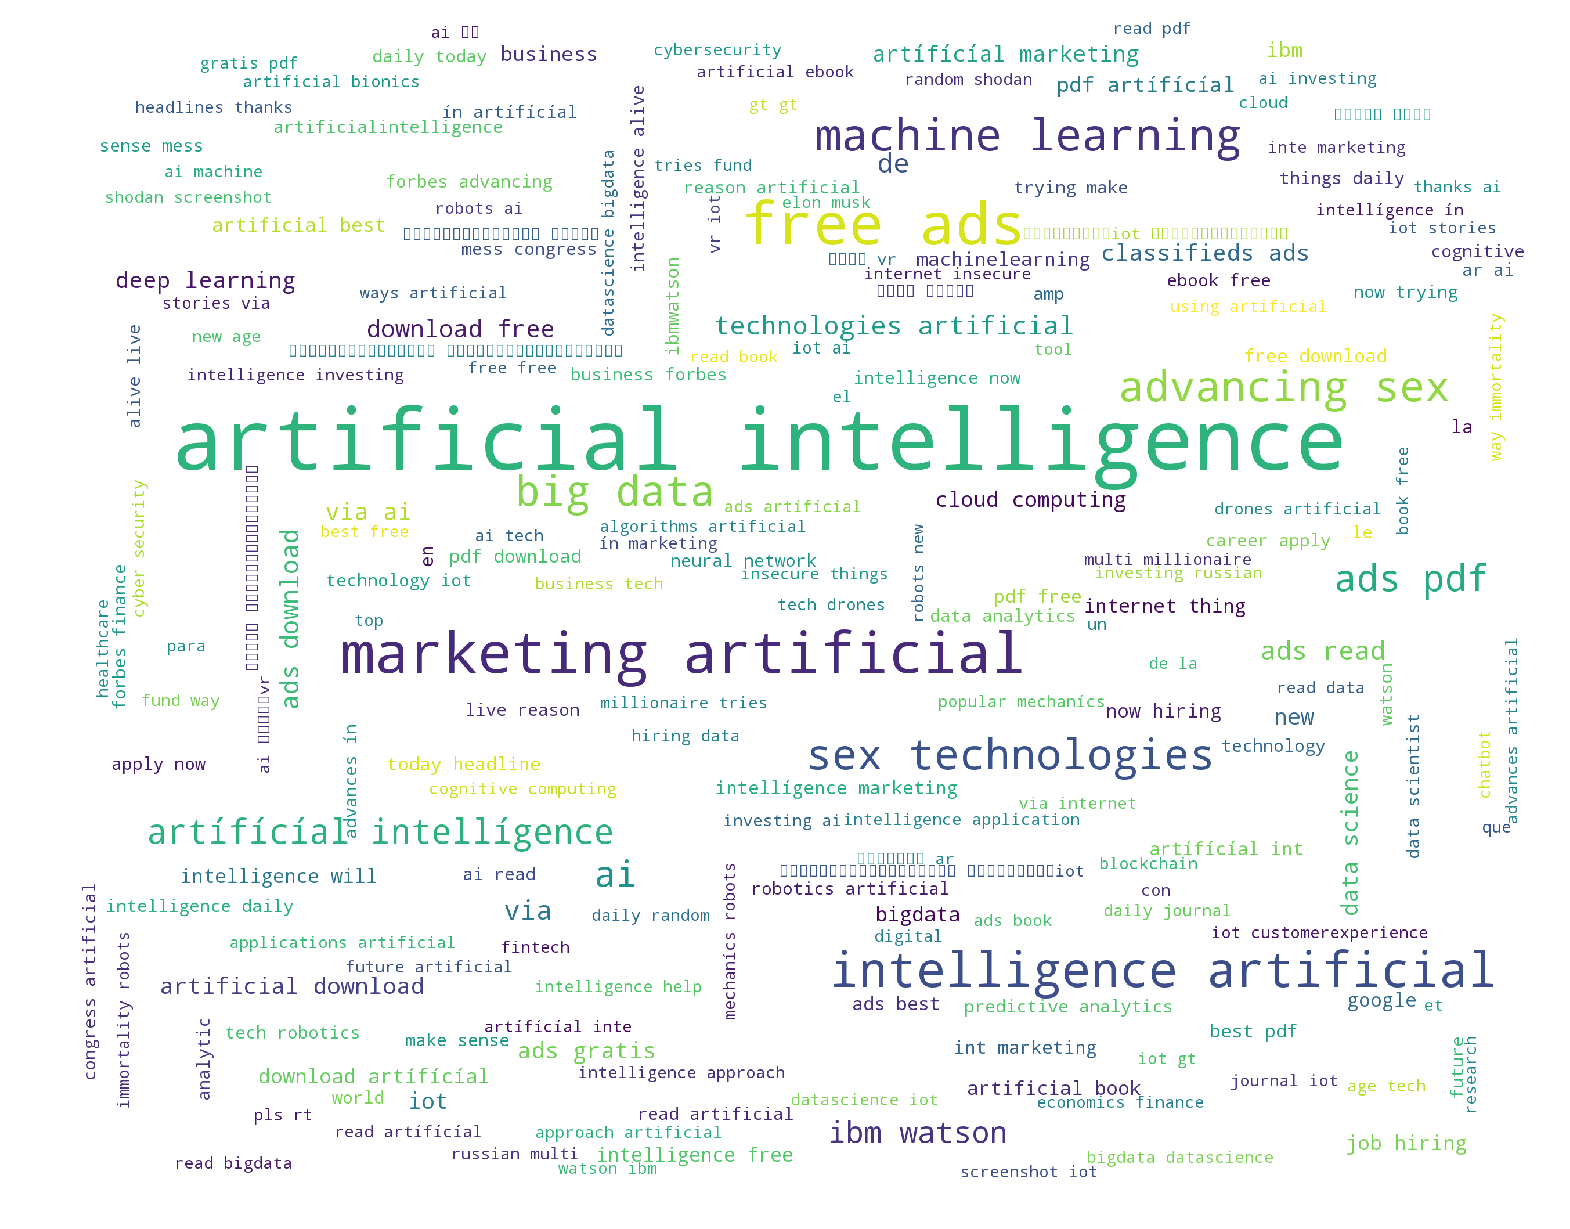

In [15]:
if 1 == 1:
    str_lst = []
    
    df_ibm = pd.read_pickle(user_ibm_pol_pkl)
    ibm_pos_ids_lst = df_ibm[df_ibm['polarity'] < 0]['uid'].tolist()
    
    for user_id in ibm_pos_ids_lst:
        user_file = os.path.join(ibm_user_sent_dir, '{}.txt'.format(user_id))
        with codecs.open(user_file, 'r', 'utf-8') as f:
            for line in f:
                str_lst.append(line)
                
    df_nonibm = pd.read_pickle(user_nonibm_pol_pkl)
    nonibm_pos_ids_lst = df_nonibm[df_nonibm['polarity'] < 0]['uid'].tolist()
    
    for user_id in nonibm_pos_ids_lst:
        user_file = os.path.join(nonibm_user_sent_dir, '{}.txt'.format(user_id))
        with codecs.open(user_file, 'r', 'utf-8') as f:
            for line in f:
                str_lst.append(line)
    
    wc_data = ''.join(str_lst)
    wc_data = preprocessTweet(wc_data)
    
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=2500, height=2000).generate(wc_data)
    plt.figure(1, figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()